In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.predict import load_model


from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import yaml
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
def standardize(X: torch.tensor):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

def scale(X):
    scaled = (X - X.min()) / (X.max() - X.min() + 1e-5)
    return scaled

def get_metrics(tomo_path, gt_tomo_path, use_deconv_data, clip_values):
    
    n2v_psnr, n2v_ssim_idx = None, None
    
    if use_deconv_data=='true':
        use_deconv_data=True
    elif use_deconv_data=='false':
        use_deconv_data=False
    
    if (tomo_path is not None) and (gt_tomo_path is not None):       
        try:
            gt_data = read_array(gt_tomo_path)
            gt_data = torch.tensor(gt_data).unsqueeze(0).unsqueeze(0)
            if clip_values:
                gt_data = clip(gt_data)
            gt_data = standardize(gt_data)

            name = tomo_path.split('/')[-1].replace('.mrc', '')

            if use_deconv_data:
                _type = 'deconv'
            else:
                _type = 'normal'

            n2v_pred_path = os.path.join(PARENT_PATH,
                                         "data/S2SDenoising/n2v_model_logs/%s/%s/%s_n2vDenoised.mrc" %(name, _type, name))
            # print(n2v_pred_path)

            n2v_data = read_array(n2v_pred_path)
            n2v_data = torch.tensor(n2v_data).unsqueeze(0).unsqueeze(0)
            if clip_values:
                n2v_data = clip(n2v_data)
            n2v_data = standardize(n2v_data)
            n2v_data = scale(n2v_data)
            gt_data = scale(gt_data)

            n2v_psnr = float(peak_signal_noise_ratio(n2v_data, gt_data, data_range=1))
            n2v_ssim_idx = float(ssim(n2v_data, gt_data, data_range=1))
            
        except OSError:
            pass

        
    return n2v_psnr, n2v_ssim_idx


def logdir_to_dataframe(logdir, clip_values, ignore_deconv=True):
    data_log = []
    keys = ['Version_comment', 'transform', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr', 'baseline_ssim',
            'tomo_path', 'gt_tomo_path', 'use_deconv_as_target', 'predict_simRecon', 'use_deconv_data', 'p']
    
    all_logs = glob(logdir+'*/*.yaml')
    
    for yaml_logdir in all_logs:
        model = yaml_logdir.split('/')[-3]
        version = yaml_logdir.split('/')[-2]
        with open(yaml_logdir) as f:
            hparams = yaml.load(f, Loader=yaml.BaseLoader)
        
        if 'dataset' in hparams.keys():
            dataset = hparams['dataset']
            
        else:
            # yaml is stupid
            with open(yaml_logdir) as f:
                s = f.readlines()
                try:
                    dataloader = [x for x in s if 'Dataloader' in x][0]
                    dataset = dataloader.split('.')[-1].replace('\n', '').replace('\'', '')
                except:
                    dataset = 'Unknown'

        row_vals = [model, version, dataset, hparams['loss_fn']['alpha']]
        for k in keys:
            try:
                row_vals += [hparams[k]]
            except KeyError:
                row_vals += [None]
        data_log.append(row_vals)

    data_log = pd.DataFrame(data_log, columns=['model', 'version', 'dataset', 'TV_alpha']+keys)
    data_log = data_log.sort_values(['model', 'version'])
    
    if ignore_deconv:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: 
                                                                                            get_metrics(x[0], x[1], 'false', clip_values),
                                                                                            axis=1)
    else:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: 
                                                                                            get_metrics(x[0], x[1], x[2], clip_values),
                                                                                            axis=1)
    data_log['n2v_psnr'], data_log['n2v_ssim'] = zip(*baseline_metrics) 
    data_log[['full_tomo_psnr', 'full_tomo_ssim']] = data_log[['full_tomo_psnr', 'full_tomo_ssim']].astype(float)
    data_log[['baseline_psnr', 'baseline_ssim']] = data_log[['baseline_psnr', 'baseline_ssim']].astype(float)
    
    data_log['baseline_psnr_best'] = data_log.baseline_psnr.max()
    data_log['baseline_ssim_best'] = data_log.baseline_ssim.max()

    tomo_path = data_log.tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)
    gt_tomo_path = data_log.gt_tomo_path#.map(lambda x: x.split('/')[-1] if x is not None else x)

    # data_log.drop(['tomo_path', 'gt_tomo_path'], axis=1, inplace=True)
    data_log['tomo_path'], data_log['gt_tomo_path'] = [tomo_path, gt_tomo_path]
    
    _vals = 100*data_log[['full_tomo_ssim', 'n2v_ssim']].apply(lambda x: (x-data_log['baseline_ssim_best'])/data_log['baseline_ssim_best'])
    data_log['ssim_vs_baseline'], data_log['n2v_ssim_vs_baseline'] = zip(*_vals.values)

    _vals = 100*data_log[['full_tomo_psnr', 'n2v_psnr']].apply(lambda x: (x-data_log['baseline_psnr_best'])/data_log['baseline_psnr_best'])
    data_log['psnr_vs_baseline'], data_log['n2v_psnr_vs_baseline'] = zip(*_vals.values)
    
    return data_log

def get_best_version(data_log, metric):
    if metric=='psnr':
        _best = data_log[data_log.full_tomo_psnr==data_log.full_tomo_psnr.max()]
        _worst = data_log[data_log.full_tomo_psnr==data_log.full_tomo_psnr.min()]
    if metric=='ssim':
        _best = data_log[data_log.full_tomo_ssim==data_log.full_tomo_ssim.max()]
        _worst = data_log[data_log.full_tomo_ssim==data_log.full_tomo_ssim.min()]
        
    best_version = _best.version.values[0]
    tomo_name = _best.tomo_path.values[0].replace('.mrc', '')
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_dropoutLevel_comparison/' %tomo_name
    logdir = os.path.join(PARENT_PATH, logdir)  
    pred_tomo_path = logdir+'%s/%s_s2sDenoised.mrc' %(best_version, tomo_name)
    gt_tomo_path = _best.gt_tomo_path.values[0]
    
    worst_version = _worst.version.values[0]
    tomo_name2 = _worst.tomo_path.values[0].replace('.mrc', '')
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_dropoutLevel_comparison/' %tomo_name2
    logdir = os.path.join(PARENT_PATH, logdir) 
    pred_tomo_path2 = logdir+'%s/%s_s2sDenoised.mrc' %(worst_version, tomo_name2)
    
    print('Best version: ', pred_tomo_path)
    print('GT file: ', gt_tomo_path)
    print('Best %s value: ' %metric, _best['full_tomo_%s' %metric])
    print('Worst %s value: ' %metric, _worst['full_tomo_%s' %metric])
    
    best = read_array(pred_tomo_path)
    gt = read_array(gt_tomo_path)
    worst = read_array(pred_tomo_path2)
    
    return best, gt, worst

# Experiment conclusions

## realBernoulli_dropoutLevel_comparison

### Gaussian + Poisson

- PSNR remains quite stable across tomoPhantom models and noise levels. Therefore is not a metric that will be used to assess the denoising.
- SSIM has an interesting behaviour. It seems to improve as more dropout is used when the noise levels are not too high (L and M cases). When noise levels are higher, however, using more dropout leads to poorer results on the predicted tomogram's SSIM.
- A counterintuitive result is that higher SSIM values are achieved for the medium noise than for the low case, which should not happen.
- As expected, the more regular our tomogram is, the better the denoising results, since the network is able to exploit more simetries.
- I am afraid that images might be too sparse in this case, since a big part of the image is only zeros. I think it is necessary to make more experiments.

# Model 8

In [3]:
tomo_list = ['tomoPhantom_model8_noisyGaussPoissVL', 'tomoPhantom_model8_noisyGaussPoissL', 'tomoPhantom_model8_noisyGaussPoissM',
             'tomoPhantom_model8_noisyGaussPoissH']

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_dropoutLevel_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=True)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},20.669752,0.071460,6.438621,0.012329,tomoPhantom_model8_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,20.081675,0.042981,6.438621,0.012329,479.596241,248.607741,221.027623,211.894029
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},20.644127,0.071896,6.438621,0.012329,tomoPhantom_model8_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,20.081675,0.042981,6.438621,0.012329,483.128678,248.607741,220.629631,211.894029
3,realBernoulli_dropoutLevel_comparison,version_2,singleCET_dataset,0,Bernoulli,{'p': '0.5'},22.350937,0.082313,6.438621,0.012329,tomoPhantom_model8_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,20.081675,0.042981,6.438621,0.012329,567.620726,248.607741,247.138568,211.894029
2,realBernoulli_dropoutLevel_comparison,version_3,singleCET_dataset,0,Bernoulli,{'p': '0.5'},25.471418,0.186610,6.438621,0.012329,tomoPhantom_model8_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.7,20.081675,0.042981,6.438621,0.012329,"1,413.549053",248.607741,295.603627,211.894029
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},20.411177,0.069836,5.918139,0.008626,tomoPhantom_model8_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,11.077742,0.012604,5.918139,0.008626,709.587367,46.114104,244.891838,87.182872
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},23.415621,0.206199,5.918139,0.008626,tomoPhantom_model8_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,11.077742,0.012604,5.918139,0.008626,"2,290.408487",46.114104,295.658547,87.182872
3,realBernoulli_dropoutLevel_comparison,version_2,singleCET_dataset,0,Bernoulli,{'p': '0.5'},24.309650,0.224276,5.918139,0.008626,tomoPhantom_model8_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,11.077742,0.012604,5.918139,0.008626,"2,499.969856",46.114104,310.765149,87.182872
2,realBernoulli_dropoutLevel_comparison,version_3,singleCET_dataset,0,Bernoulli,{'p': '0.5'},23.642157,0.491016,5.918139,0.008626,tomoPhantom_model8_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.7,11.077742,0.012604,5.918139,0.008626,"5,592.223565",46.114104,299.486369,87.182872
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},20.608261,0.061961,5.764248,0.006573,tomoPhantom_model8_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,12.535457,0.021527,5.764248,0.006573,842.602049,227.483093,257.518647,117.469076
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},22.992678,0.129475,5.764248,0.006573,tomoPhantom_model8_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,12.535457,0.021527,5.764248,0.006573,"1,869.696008",227.483093,298.884262,117.469076


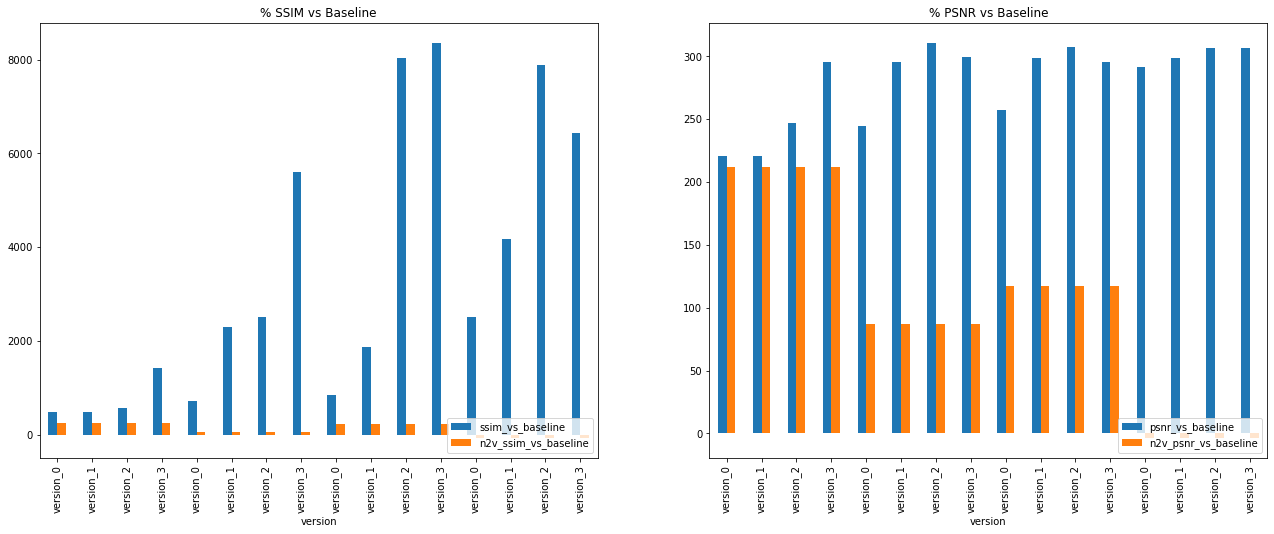

In [4]:
######### Gains wrt baseline (input)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

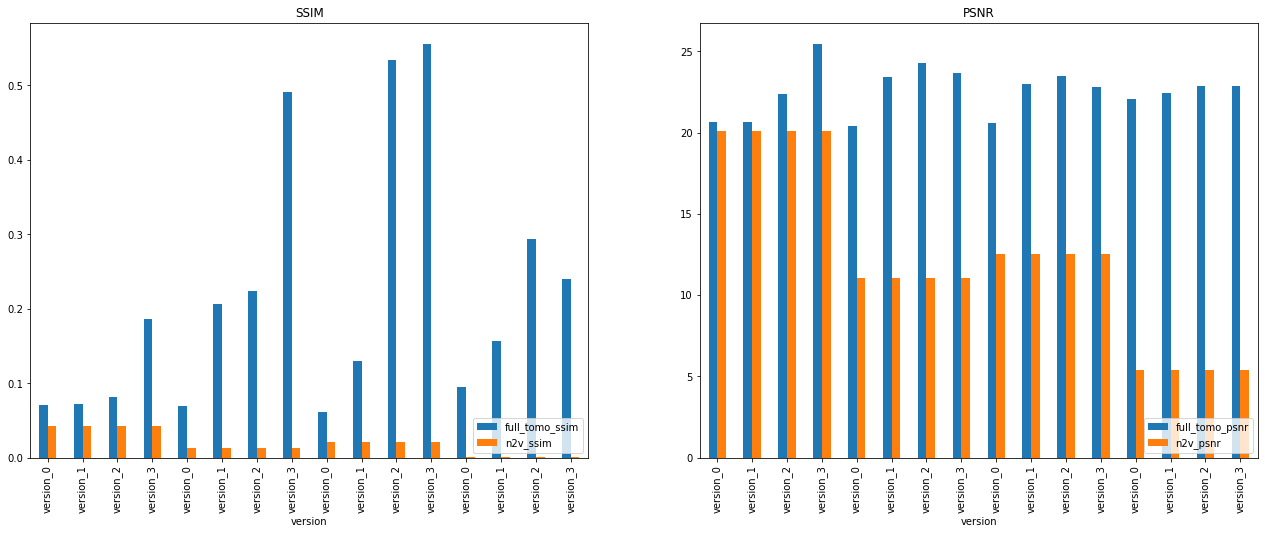

In [5]:
######### Values
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'full_tomo_ssim', 'n2v_ssim']].plot.bar(x='version', ax=ax0)
ax0.set_title('SSIM')
ax0.legend(loc='lower right')

data_log[['version', 'full_tomo_psnr', 'n2v_psnr']].plot.bar(x='version', ax=ax1)
ax1.set_title('PSNR')
ax1.legend(loc='lower right')

Best version:  /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model8_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_3/tomoPhantom_model8_noisyGaussPoissM_s2sDenoised.mrc
GT file:  /home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model8.mrc
Best ssim value:  2   0.556161
Name: full_tomo_ssim, dtype: float64
Worst ssim value:  0   0.061961
Name: full_tomo_ssim, dtype: float64


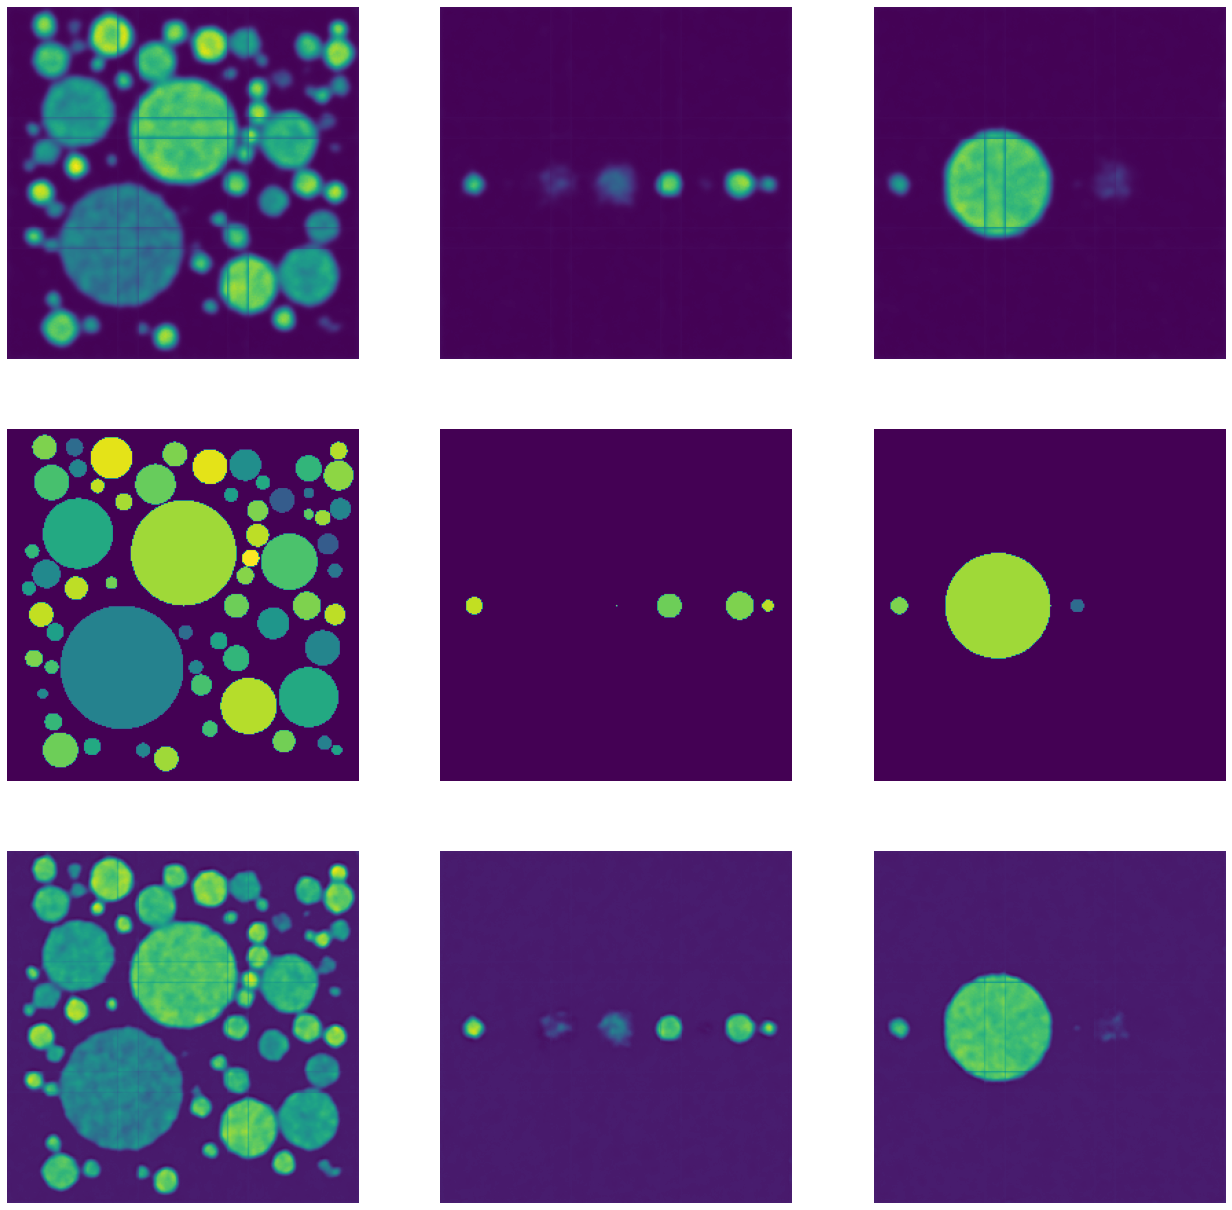

In [6]:
best, gt, worst = get_best_version(data_log, 'ssim')
best, gt, worst = scale(best), scale(gt), scale(worst)

fig, (ax0, ax1, ax2) = plt.subplots(3, 3, figsize=(22, 22))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1, ax2]).ravel()))
zidx, yidx, xidx = np.array(best.shape)//2
# zidx, yidx, xidx = np.array(best.shape)//4

ax0[0].imshow(best[zidx], vmin=0, vmax=1)
ax0[1].imshow(best[:, yidx, :], vmin=0, vmax=1)
ax0[2].imshow(best[:, :, xidx], vmin=0, vmax=1)
ax1[0].imshow(gt[zidx], vmin=0, vmax=1)
ax1[1].imshow(gt[:, yidx, :], vmin=0, vmax=1)
ax1[2].imshow(gt[:, :, xidx], vmin=0, vmax=1)
ax2[0].imshow(worst[zidx], vmin=0, vmax=1)
ax2[1].imshow(worst[:, yidx, :], vmin=0, vmax=1)
ax2[2].imshow(worst[:, :, xidx], vmin=0, vmax=1)

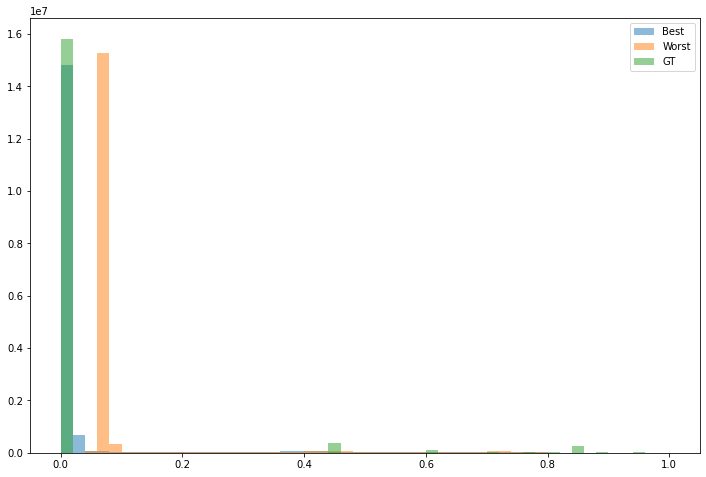

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(best.flatten(),alpha=0.5, label="Best", bins=50)
plt.hist(worst.flatten(),alpha=0.5, label="Worst", bins=50)
plt.hist(gt.flatten(), alpha=0.5, label="GT", bins=50)
plt.legend()

In [8]:
X = torch.tensor(scale(best[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

0.4894435703754425 0.40869712829589844


In [9]:
X = torch.tensor(scale(best[:, yidx, :])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

0.607086718082428 0.048711858689785004


# Model 14

In [11]:
tomo_list = [
    'tomoPhantom_model14_noisyGaussPoissVL',
    'tomoPhantom_model14_noisyGaussPoissL',
    'tomoPhantom_model14_noisyGaussPoissM',
    'tomoPhantom_model14_noisyGaussPoissH'
            ]

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_dropoutLevel_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=False)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},22.896154,0.093642,6.655292,0.009505,tomoPhantom_model14_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,13.582712,0.036350,6.655292,0.009505,885.189367,282.436022,244.029297,104.088898
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},23.680855,0.097772,6.655292,0.009505,tomoPhantom_model14_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,13.582712,0.036350,6.655292,0.009505,928.643063,282.436022,255.819920,104.088898
3,realBernoulli_dropoutLevel_comparison,version_2,singleCET_dataset,0,Bernoulli,{'p': '0.5'},24.705984,0.110062,6.655292,0.009505,tomoPhantom_model14_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,13.582712,0.036350,6.655292,0.009505,"1,057.945228",282.436022,271.223141,104.088898
2,realBernoulli_dropoutLevel_comparison,version_3,singleCET_dataset,0,Bernoulli,{'p': '0.5'},26.049292,0.137295,6.655292,0.009505,tomoPhantom_model14_noisyGaussPoissVL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.7,13.582712,0.036350,6.655292,0.009505,"1,344.456161",282.436022,291.407191,104.088898
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},25.189774,0.222679,5.925602,0.005627,tomoPhantom_model14_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,6.599268,0.021486,5.925602,0.005627,"3,857.299722",281.826859,325.100669,11.368743
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},25.595102,0.158975,5.925602,0.005627,tomoPhantom_model14_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,6.599268,0.021486,5.925602,0.005627,"2,725.203437",281.826859,331.940965,11.368743
3,realBernoulli_dropoutLevel_comparison,version_2,singleCET_dataset,0,Bernoulli,{'p': '0.5'},26.051474,0.151886,5.925602,0.005627,tomoPhantom_model14_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,6.599268,0.021486,5.925602,0.005627,"2,599.220117",281.826859,339.642652,11.368743
2,realBernoulli_dropoutLevel_comparison,version_3,singleCET_dataset,0,Bernoulli,{'p': '0.5'},26.861822,0.275165,5.925602,0.005627,tomoPhantom_model14_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.7,6.599268,0.021486,5.925602,0.005627,"4,790.044850",281.826859,353.318031,11.368743
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},23.438334,0.086084,5.764930,0.003691,tomoPhantom_model14_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,6.384581,0.008522,5.764930,0.003691,"2,232.477458",130.917025,306.567546,10.748636
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},25.382448,0.158234,5.764930,0.003691,tomoPhantom_model14_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,6.384581,0.008522,5.764930,0.003691,"4,187.395222",130.917025,340.290675,10.748636


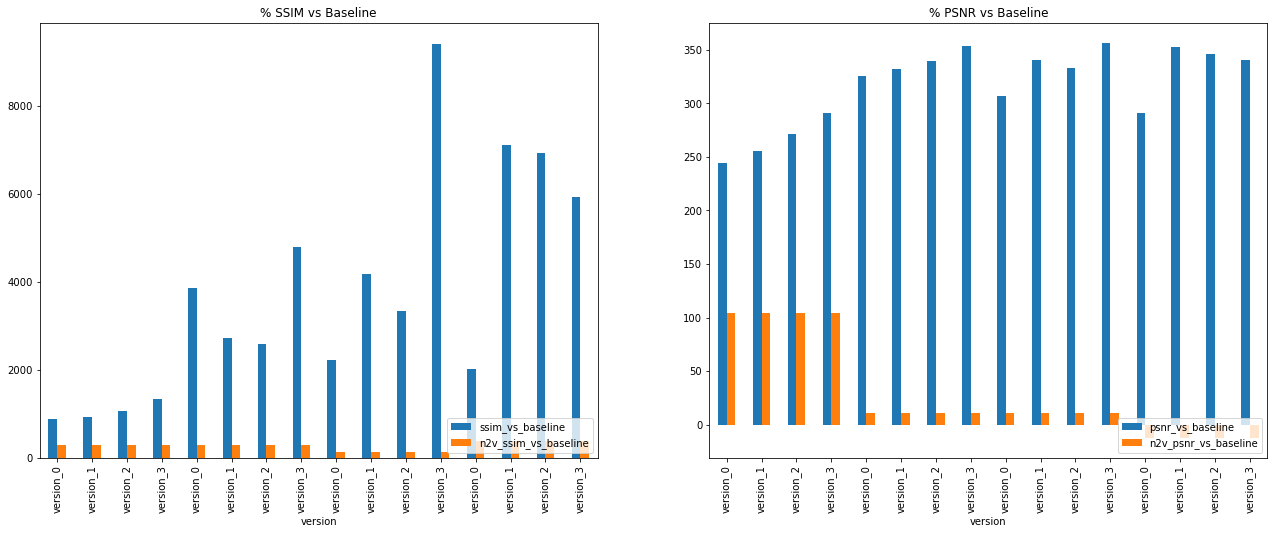

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

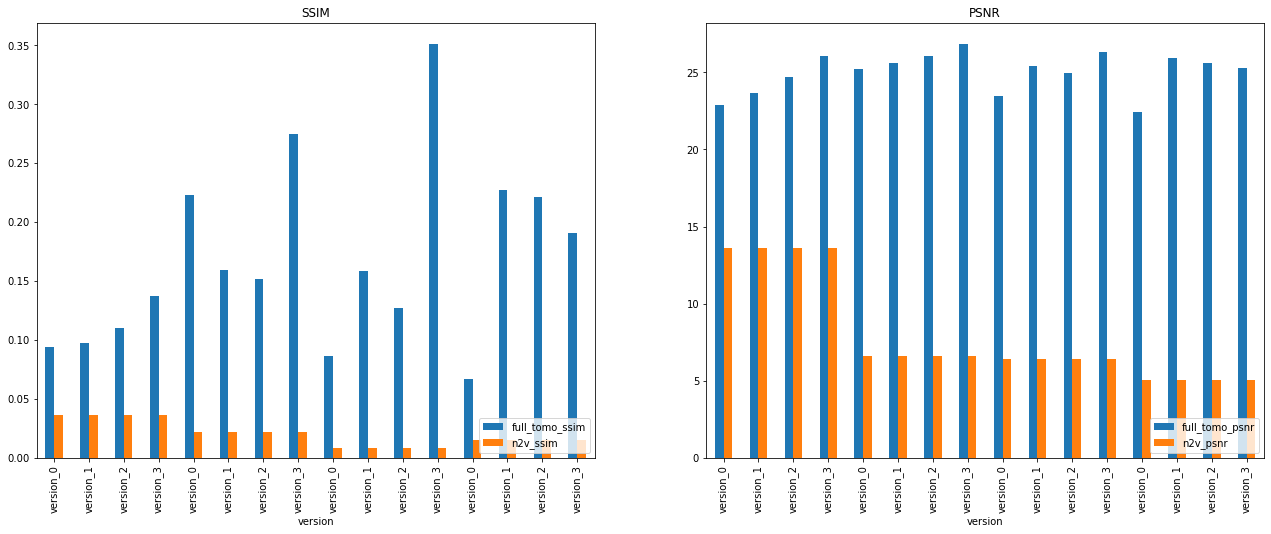

In [13]:
######### Values
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'full_tomo_ssim', 'n2v_ssim']].plot.bar(x='version', ax=ax0)
ax0.set_title('SSIM')
ax0.legend(loc='lower right')

data_log[['version', 'full_tomo_psnr', 'n2v_psnr']].plot.bar(x='version', ax=ax1)
ax1.set_title('PSNR')
ax1.legend(loc='lower right')

Best version:  /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model14_noisyGaussPoissM/realBernoulli_dropoutLevel_comparison/version_3/tomoPhantom_model14_noisyGaussPoissM_s2sDenoised.mrc
GT file:  /home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model14.mrc
Best ssim value:  2   0.351457
Name: full_tomo_ssim, dtype: float64
Worst ssim value:  0   0.066715
Name: full_tomo_ssim, dtype: float64


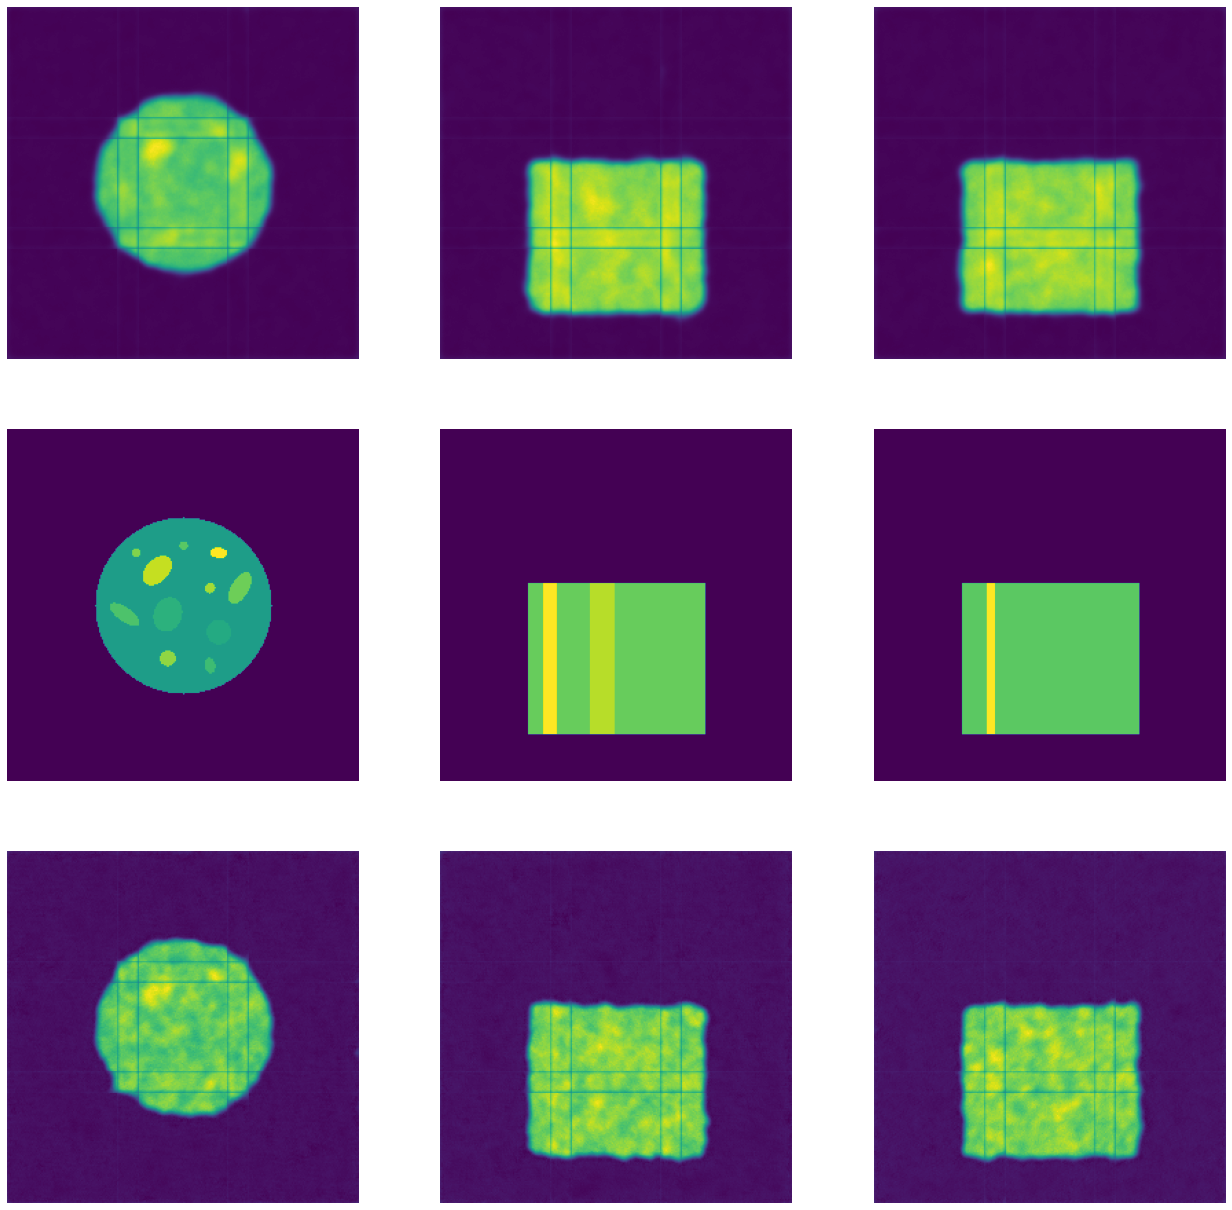

In [14]:
best, gt, worst = get_best_version(data_log, 'ssim')
best, gt, worst = scale(best), scale(gt), scale(worst)

fig, (ax0, ax1, ax2) = plt.subplots(3, 3, figsize=(22, 22))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1, ax2]).ravel()))
zidx, yidx, xidx = np.array(best.shape)//2
# zidx, yidx, xidx = np.array(best.shape)//4

ax0[0].imshow(best[zidx])
ax0[1].imshow(best[:, yidx, :])
ax0[2].imshow(best[:, :, xidx])
ax1[0].imshow(gt[zidx])
ax1[1].imshow(gt[:, yidx, :])
ax1[2].imshow(gt[:, :, xidx])
ax2[0].imshow(worst[zidx])
ax2[1].imshow(worst[:, yidx, :])
ax2[2].imshow(worst[:, :, xidx])

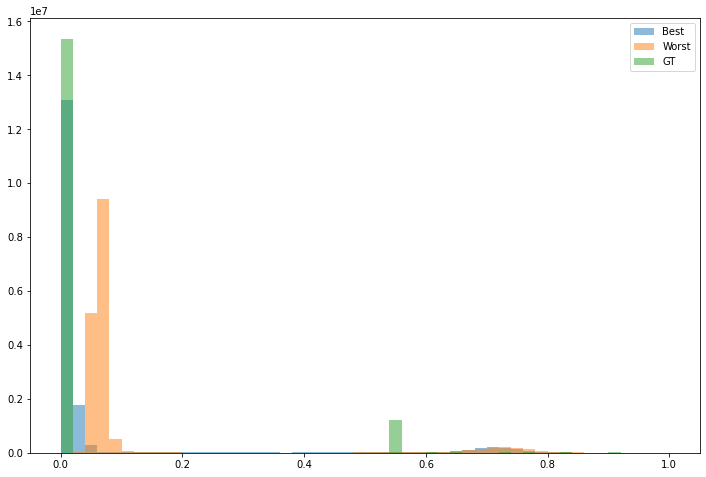

In [15]:
plt.figure(figsize=(12, 8))
plt.hist(best.flatten(),alpha=0.5, label="Best", bins=50)
plt.hist(worst.flatten(),alpha=0.5, label="Worst", bins=50)
plt.hist(gt.flatten(), alpha=0.5, label="GT", bins=50)
plt.legend()

In [16]:
X = torch.tensor(scale(best[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

0.49192285537719727 0.14867860078811646


In [17]:
X = torch.tensor(scale(best[:, yidx, :])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

0.4376688003540039 0.1500033289194107


# Model 16

In [17]:
tomo_list = [
    'tomoPhantom_model16_noisyGaussPoissVL',
    'tomoPhantom_model16_noisyGaussPoissL',
    'tomoPhantom_model16_noisyGaussPoissM',
    'tomoPhantom_model16_noisyGaussPoissH'
            ]

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_dropoutLevel_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=False)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},18.528242,0.626818,7.423662,0.035261,tomoPhantom_model16_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,9.501873,0.199529,7.423662,0.035261,"1,677.636200",465.858931,149.583600,27.994424
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},18.579151,0.627887,7.423662,0.035261,tomoPhantom_model16_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,9.501873,0.199529,7.423662,0.035261,"1,680.669568",465.858931,150.269367,27.994424
3,realBernoulli_dropoutLevel_comparison,version_2,singleCET_dataset,0,Bernoulli,{'p': '0.5'},19.095461,0.631625,7.423662,0.035261,tomoPhantom_model16_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,9.501873,0.199529,7.423662,0.035261,"1,691.268185",465.858931,157.224287,27.994424
2,realBernoulli_dropoutLevel_comparison,version_3,singleCET_dataset,0,Bernoulli,{'p': '0.5'},19.308481,0.620170,7.423662,0.035261,tomoPhantom_model16_noisyGaussPoissL.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.7,9.501873,0.199529,7.423662,0.035261,"1,658.784354",465.858931,160.093765,27.994424
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},16.964403,0.575780,6.563539,0.022479,tomoPhantom_model16_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,6.853559,0.059967,6.563539,0.022479,"2,461.447405",166.773941,158.464269,4.418645
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},18.441793,0.597789,6.563539,0.022479,tomoPhantom_model16_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,6.853559,0.059967,6.563539,0.022479,"2,559.356590",166.773941,180.973319,4.418645
3,realBernoulli_dropoutLevel_comparison,version_2,singleCET_dataset,0,Bernoulli,{'p': '0.5'},18.329849,0.604997,6.563539,0.022479,tomoPhantom_model16_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.5,6.853559,0.059967,6.563539,0.022479,"2,591.423508",166.773941,179.267773,4.418645
2,realBernoulli_dropoutLevel_comparison,version_3,singleCET_dataset,0,Bernoulli,{'p': '0.5'},19.137535,0.600790,6.563539,0.022479,tomoPhantom_model16_noisyGaussPoissM.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.7,6.853559,0.059967,6.563539,0.022479,"2,572.706095",166.773941,191.573418,4.418645
0,realBernoulli_dropoutLevel_comparison,version_0,singleCET_dataset,0,Bernoulli,{'p': '0.5'},17.150368,0.565461,6.362285,0.019649,tomoPhantom_model16_noisyGaussPoissH.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.1,6.850172,0.054499,6.362285,0.019649,"2,777.840390",177.364529,169.563017,7.668415
1,realBernoulli_dropoutLevel_comparison,version_1,singleCET_dataset,0,Bernoulli,{'p': '0.5'},18.052919,0.581770,6.362285,0.019649,tomoPhantom_model16_noisyGaussPoissH.mrc,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,null,null,false,0.3,6.850172,0.054499,6.362285,0.019649,"2,860.840613",177.364529,183.748983,7.668415


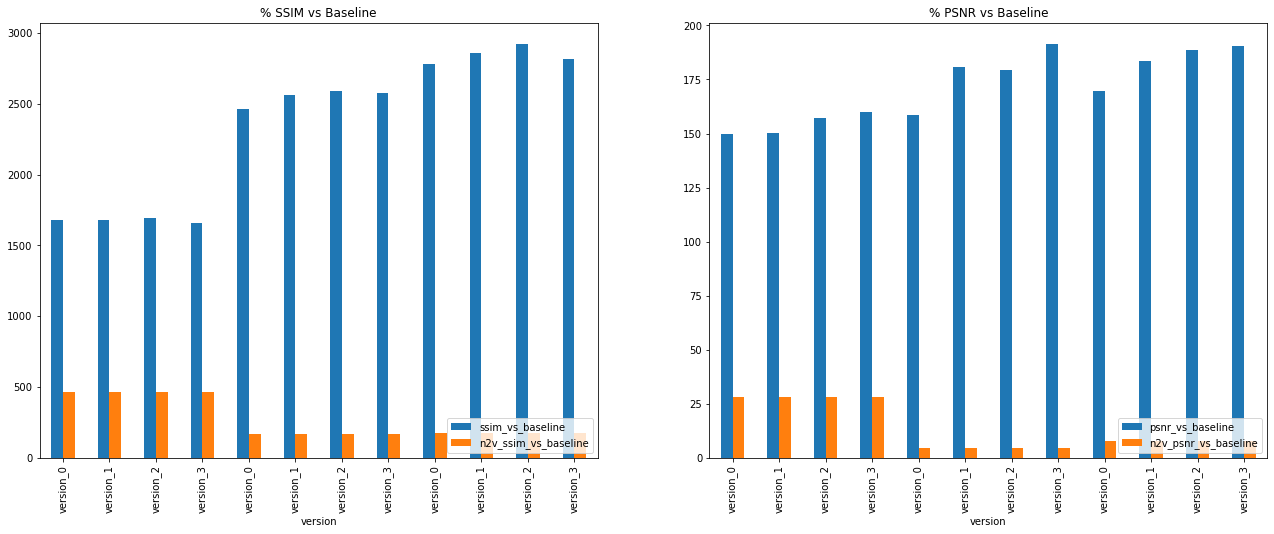

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

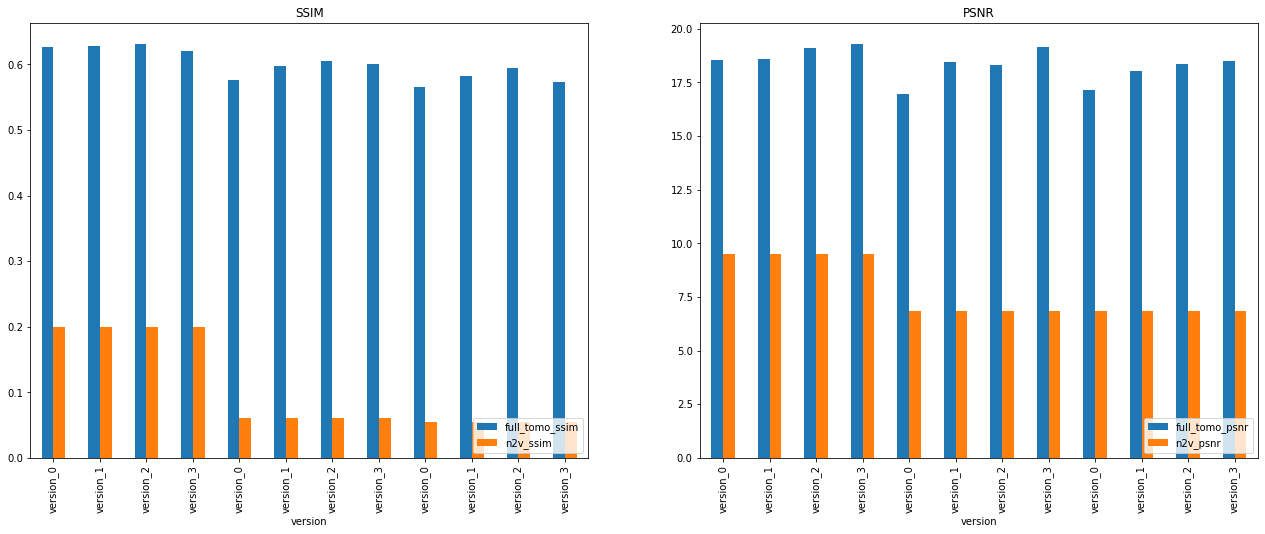

In [19]:
######### Values
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'full_tomo_ssim', 'n2v_ssim']].plot.bar(x='version', ax=ax0)
ax0.set_title('SSIM')
ax0.legend(loc='lower right')

data_log[['version', 'full_tomo_psnr', 'n2v_psnr']].plot.bar(x='version', ax=ax1)
ax1.set_title('PSNR')
ax1.legend(loc='lower right')

Best version:  /home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model16_noisyGaussPoissL/realBernoulli_dropoutLevel_comparison/version_2/tomoPhantom_model16_noisyGaussPoissL_s2sDenoised.mrc
GT file:  /home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model16.mrc
Best ssim value:  3   0.631625
Name: full_tomo_ssim, dtype: float64
Worst ssim value:  0   0.565461
Name: full_tomo_ssim, dtype: float64


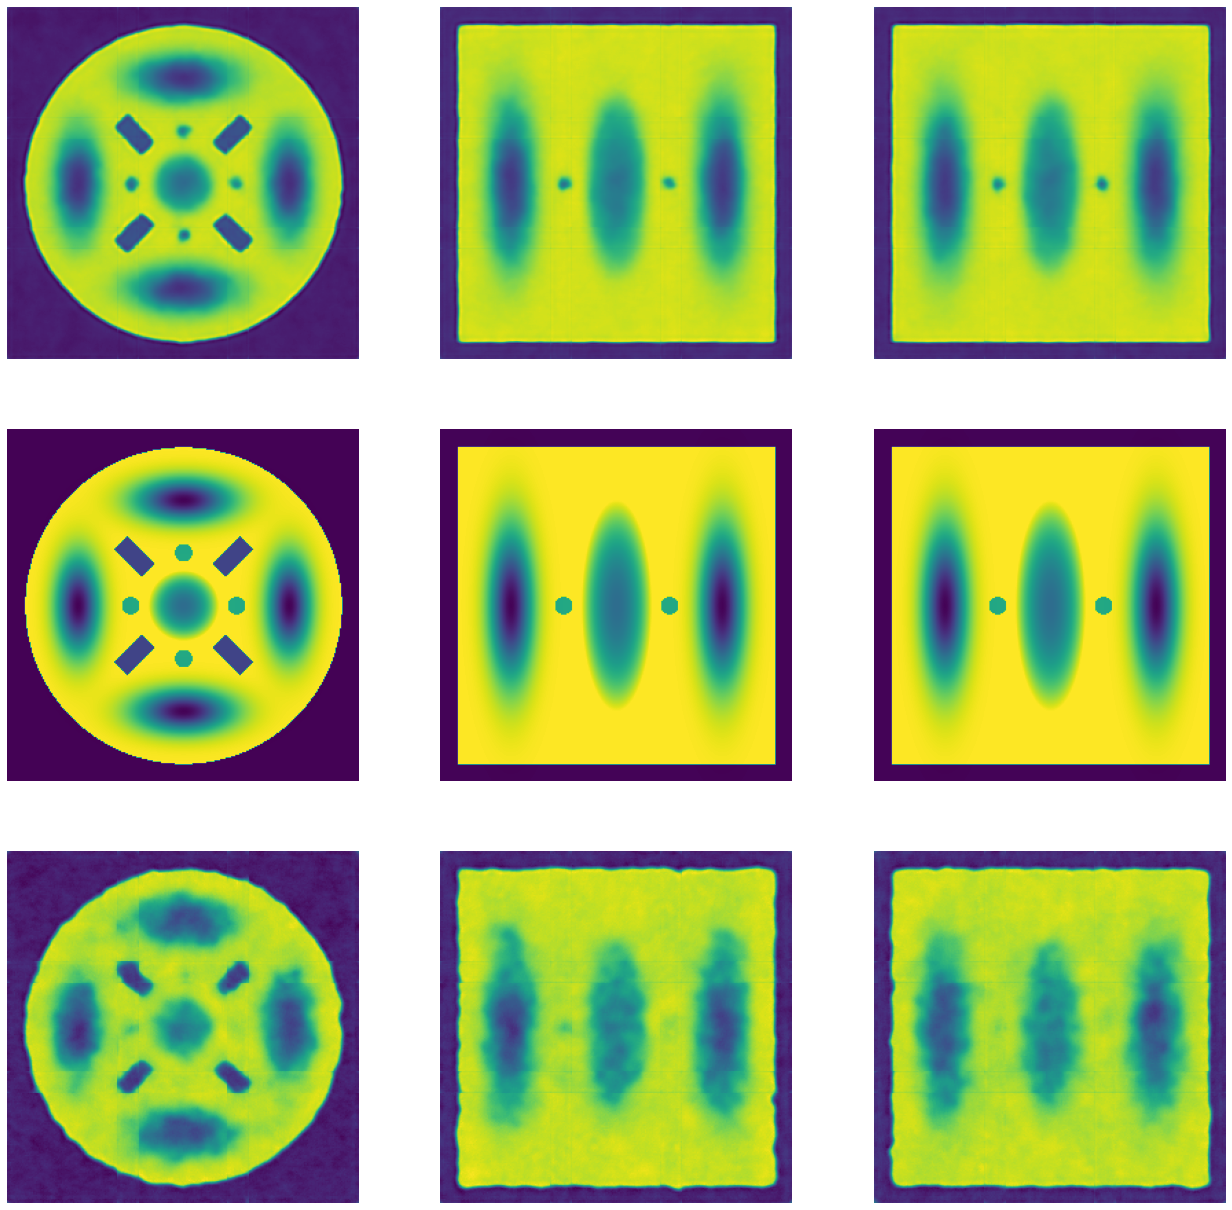

In [20]:
best, gt, worst = get_best_version(data_log, 'ssim')
best, gt, worst = scale(best), scale(gt), scale(worst)

fig, (ax0, ax1, ax2) = plt.subplots(3, 3, figsize=(22, 22))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1, ax2]).ravel()))
zidx, yidx, xidx = np.array(best.shape)//2
# zidx, yidx, xidx = np.array(best.shape)//4

ax0[0].imshow(best[zidx])
ax0[1].imshow(best[:, yidx, :])
ax0[2].imshow(best[:, :, xidx])
ax1[0].imshow(gt[zidx])
ax1[1].imshow(gt[:, yidx, :])
ax1[2].imshow(gt[:, :, xidx])
ax2[0].imshow(worst[zidx])
ax2[1].imshow(worst[:, yidx, :])
ax2[2].imshow(worst[:, :, xidx])

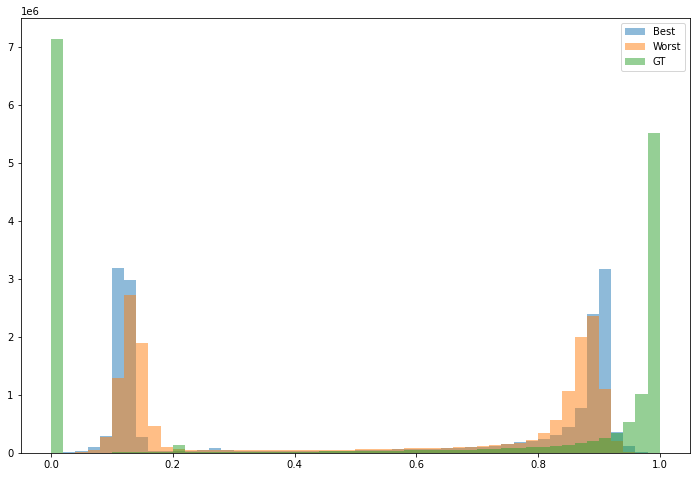

In [21]:
plt.figure(figsize=(12, 8))
plt.hist(best.flatten(),alpha=0.5, label="Best", bins=50)
plt.hist(worst.flatten(),alpha=0.5, label="Worst", bins=50)
plt.hist(gt.flatten(), alpha=0.5, label="GT", bins=50)
plt.legend()

In [22]:
X = torch.tensor(scale(best[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

0.7026730179786682 0.6112412214279175


In [23]:
X = torch.tensor(scale(best[:, yidx, :])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

0.8752816915512085 0.7875683307647705
